# Clustering analysis with Adversarial Autoencoders on 10k PBMC data

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

In [16]:
np.random.multinomial(1, [1/6.]*6, size=1)

array([[0, 0, 1, 0, 0, 0]])

## 1. Adversarial Autoencoder: Unsupervised Model

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
batch_size,35,batch size
epochs,50,number of epochs
alpha,0.1,alpha coeff. in activation function
do_rate,0.1,dropout rate
kernel_initializer,glorot_uniform,kernel initializer of all dense layers
bias_initializer,zeros,bias initializer of all dense layers
l2_weight,0.01,weight of l2 kernel regularization
l1_weight,0.01,weight of l1 activity regularization
lr_dis,0.0001,learning rate discriminator
lr_gen,0.0001,learning rate generator


In [10]:
# Build the full model

model.build_model()

In [11]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1', exist_ok=True)
model.export_graph('../graphs/AAE1')

Model graphs saved.



### Visualize graphs


ENCODER


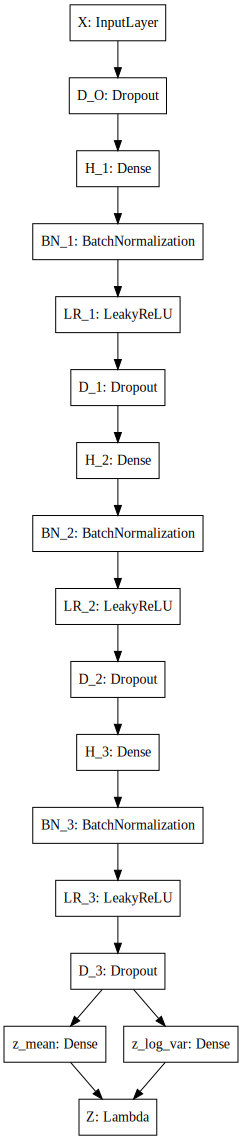

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


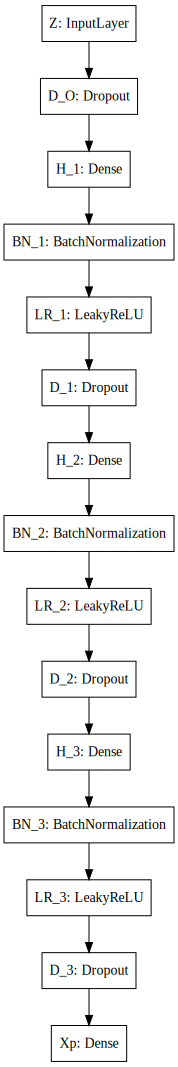

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


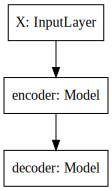

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


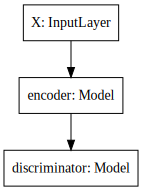

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


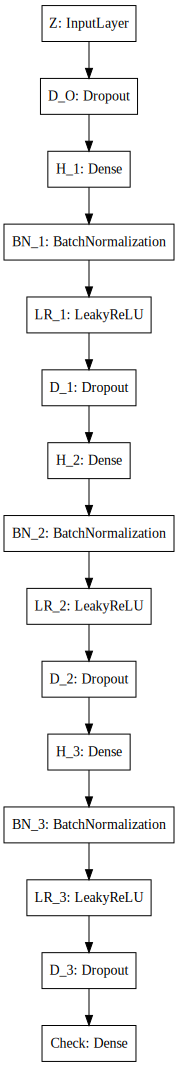

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 0.912380, generation loss: 0.435545, discriminator loss: 0.285745


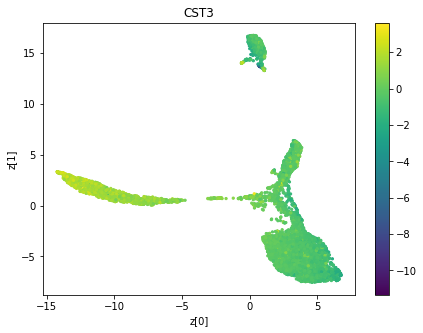

Training completed.


In [14]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1', exist_ok=True)
model.export_model('../models/AAE1')

Adversarial Autoencoder networks exported in h5 format.


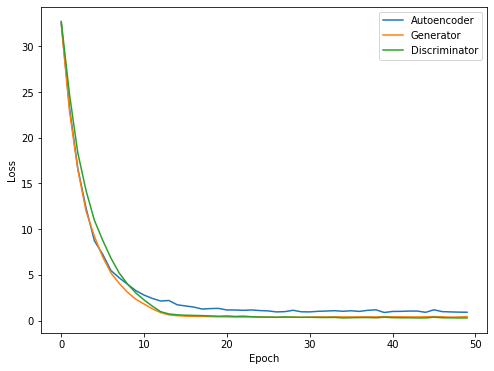

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

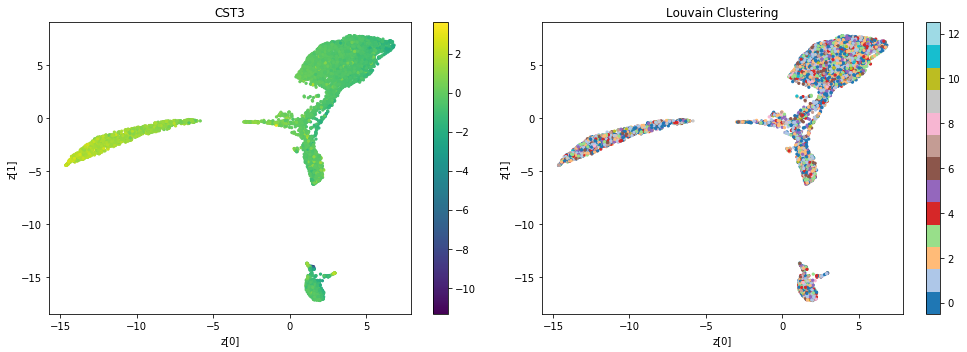

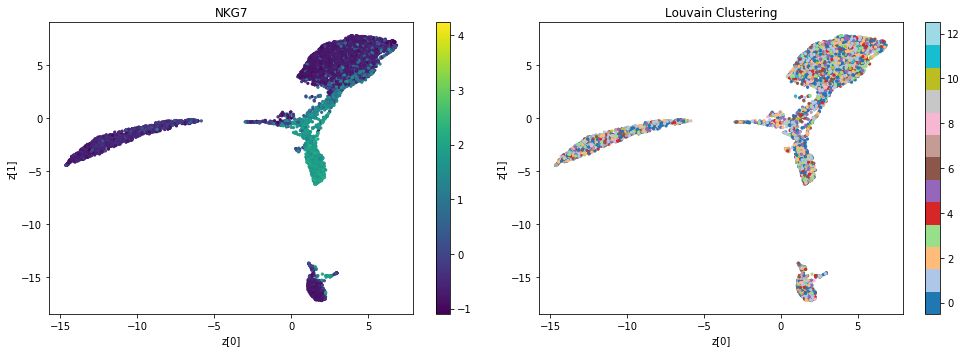

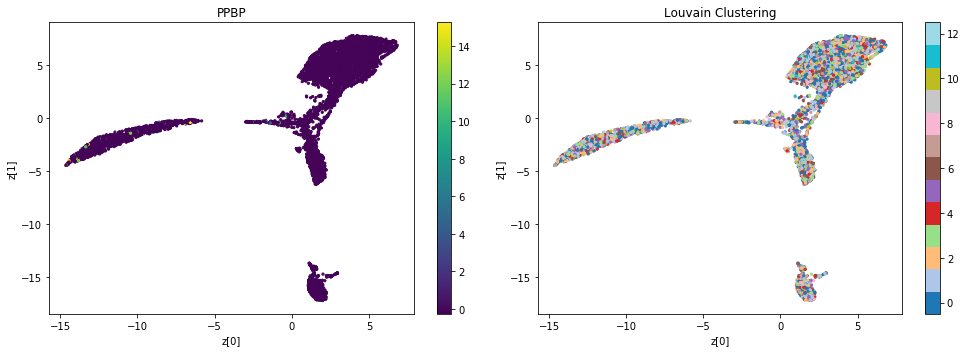

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## 2. Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [8]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2', exist_ok=True)
model.export_graph('../graphs/AAE2')

Model graphs saved.



### Visualize graphs


ENCODER


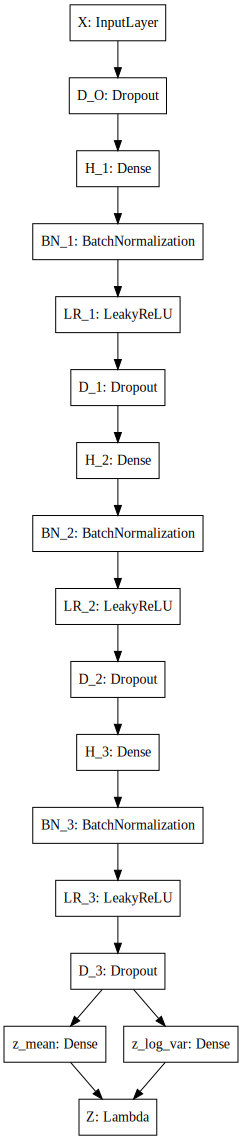

In [12]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


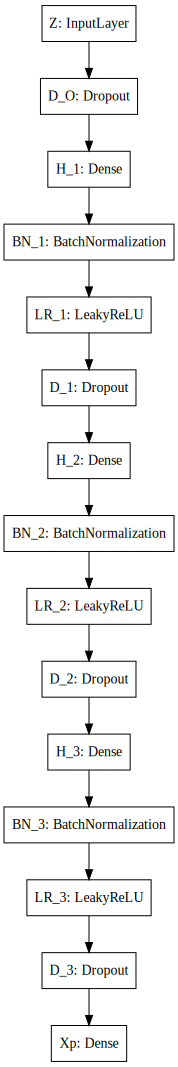

In [13]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


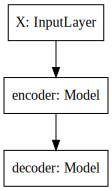

In [14]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


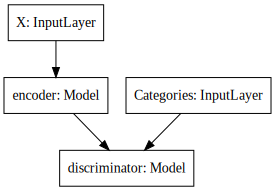

In [15]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


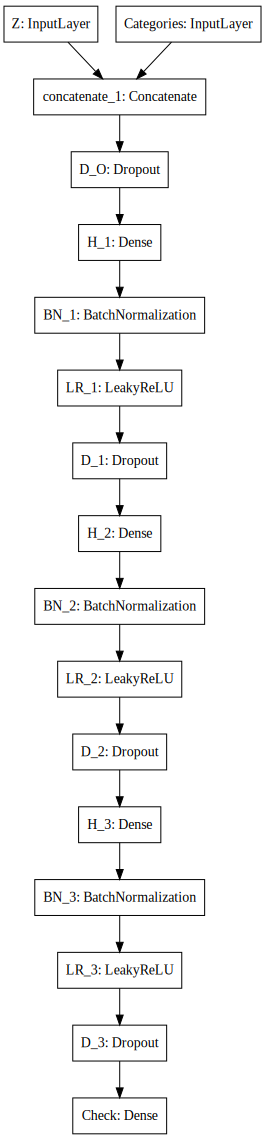

In [16]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 0.969549, generation loss: 0.375600, discriminator loss: 0.294835


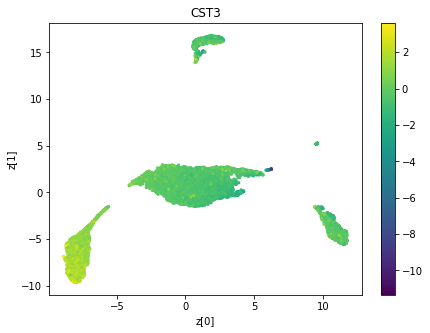

Training completed.


In [9]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [ ]:
# save models in h5 format
os.makedirs('../models/AAE2', exist_ok=True)
model.export_model('../models/AAE2')

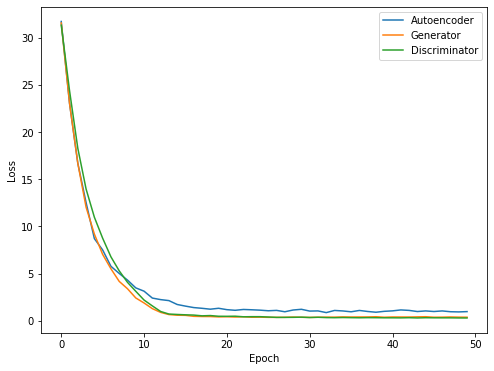

In [10]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

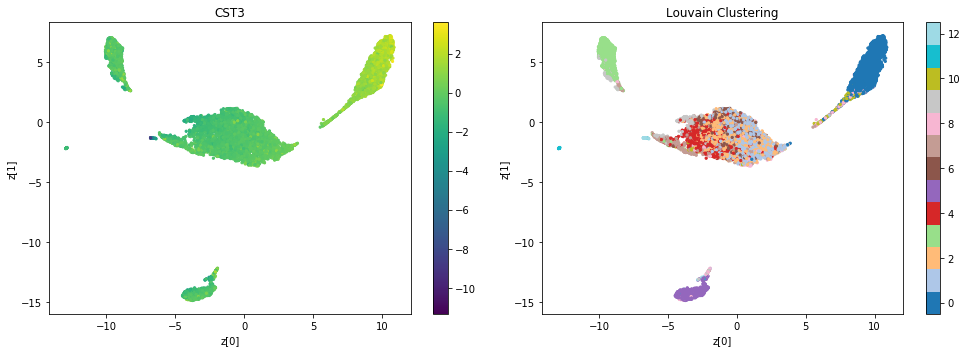

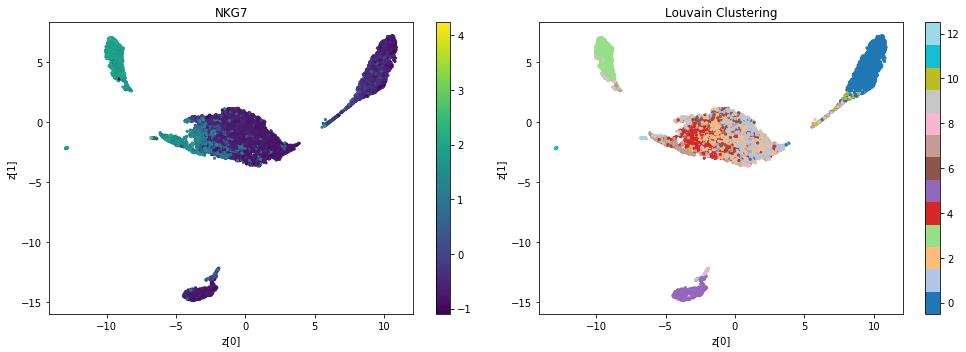

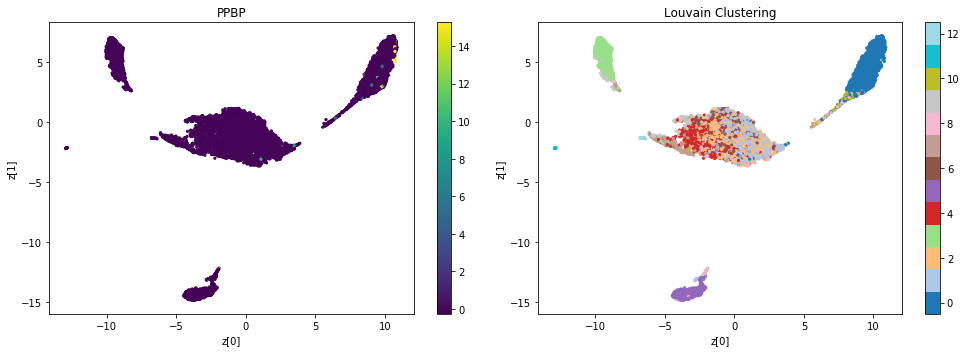

In [11]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## 3. Supervised Adversarial Autoencoder

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE3(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc10k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1789)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1789)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          178900      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2', exist_ok=True)
model.export_graph('../graphs/AAE2')

Model graphs saved.



### Visualize graphs


ENCODER


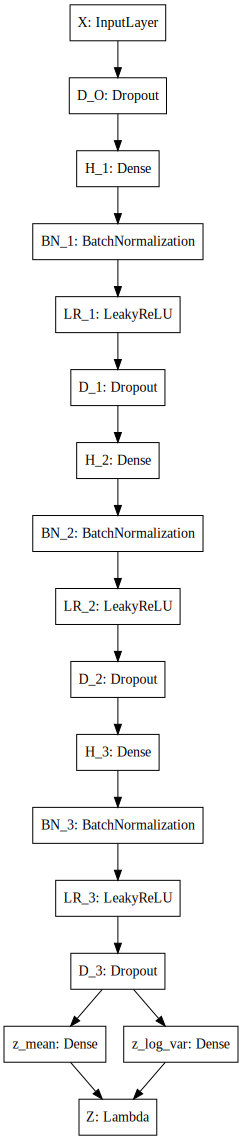

In [10]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


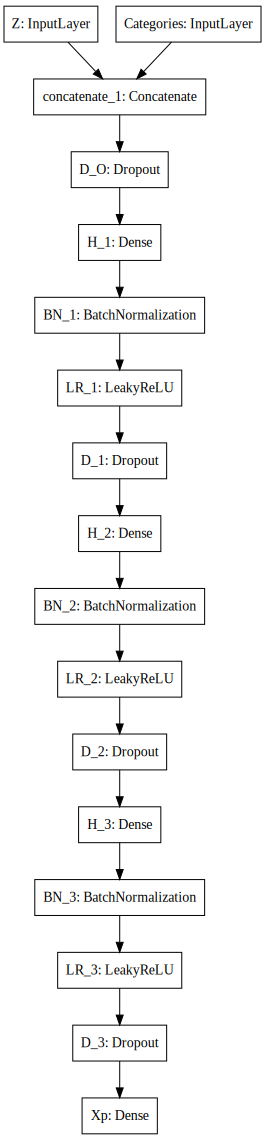

In [11]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


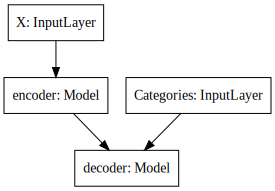

In [12]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


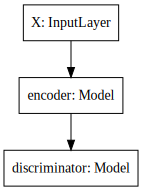

In [13]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


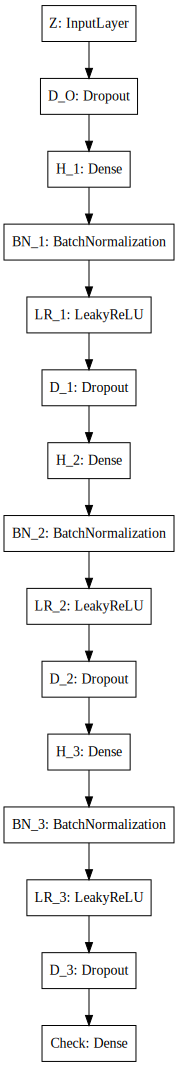

In [14]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.125866, generation loss: 0.403079, discriminator loss: 0.302218


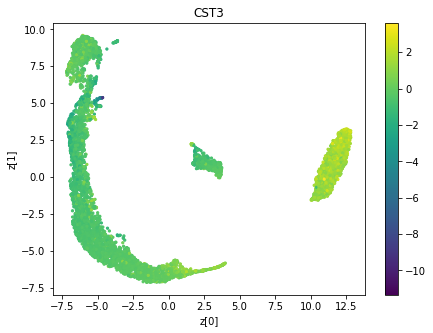

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2', exist_ok=True)
model.export_model('../models/AAE2')

All networks exported in h5 format.


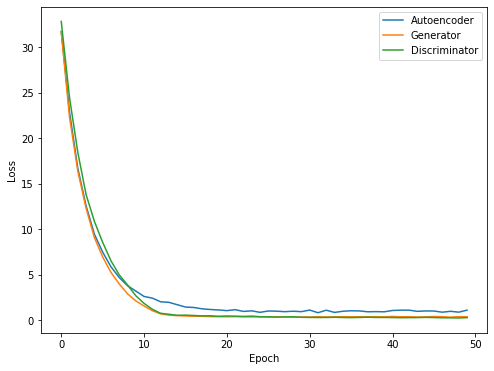

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

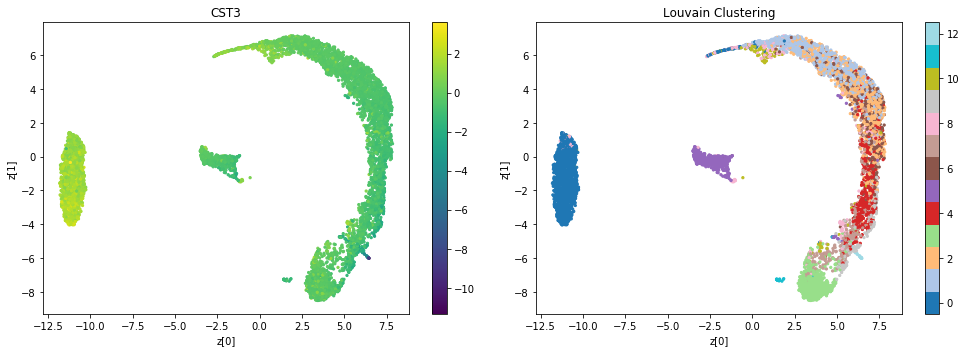

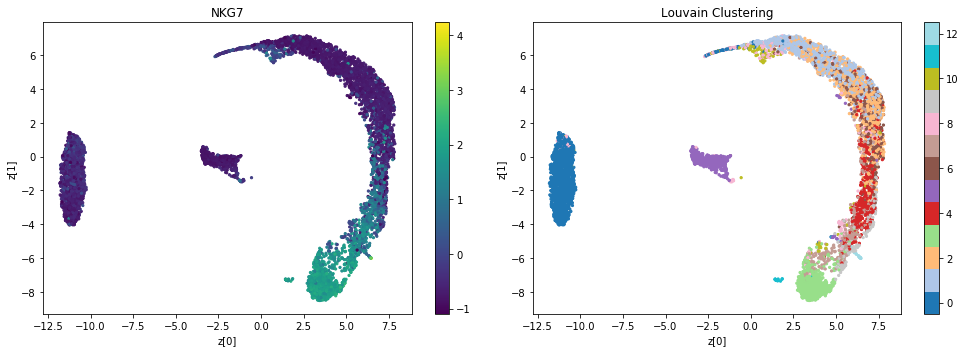

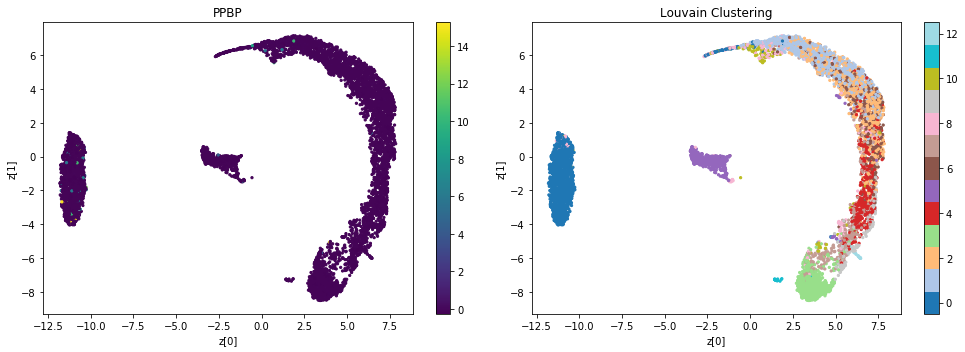

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis with Adversarial Autoencoders on 8k PBMC data

<img src="img/adversarial_autoencoder_model.png" width="800px" style="float:center" >

In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## 1. Adversarial Autoencoder: Unsupervised Model

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1', exist_ok=True)
model.export_graph('../graphs/AAE1')

Model graphs saved.



### Visualize graphs


ENCODER


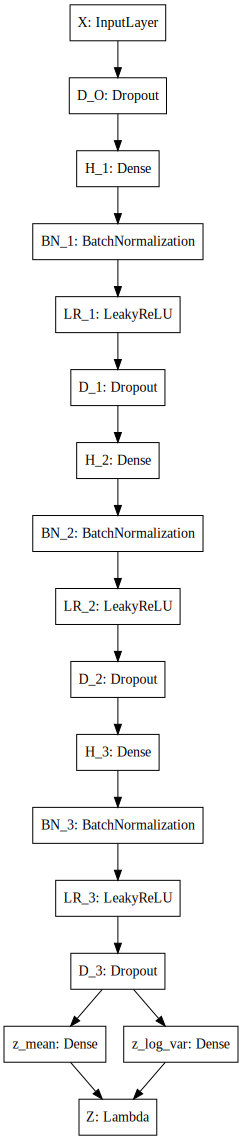

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


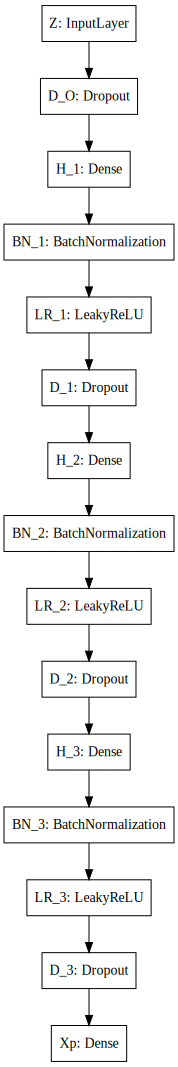

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


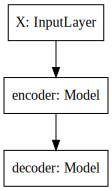

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


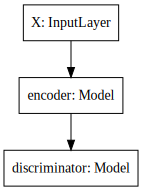

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


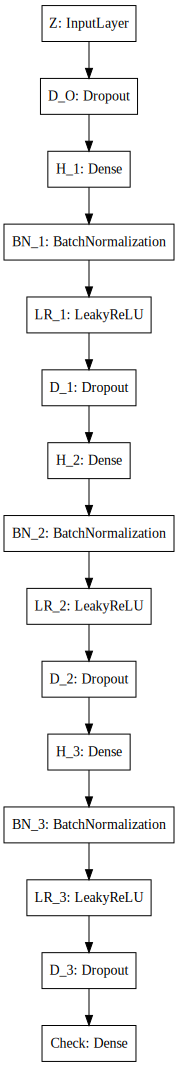

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.037190, generation loss: 0.409361, discriminator loss: 0.307326


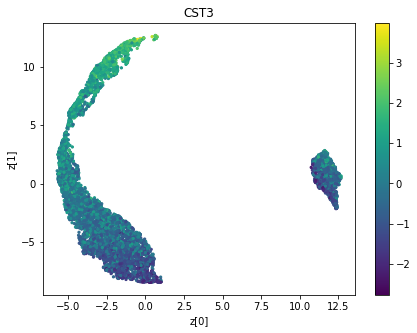

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1', exist_ok=True)
model.export_model('../models/AAE1')

Adversarial Autoencoder networks exported in h5 format.


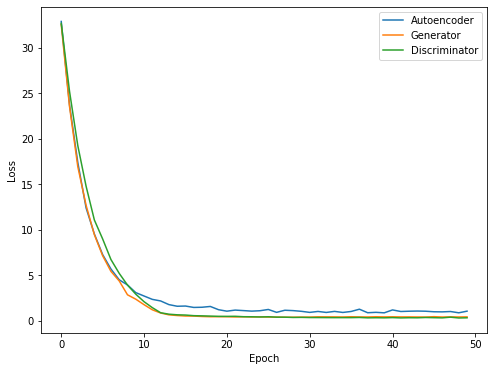

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

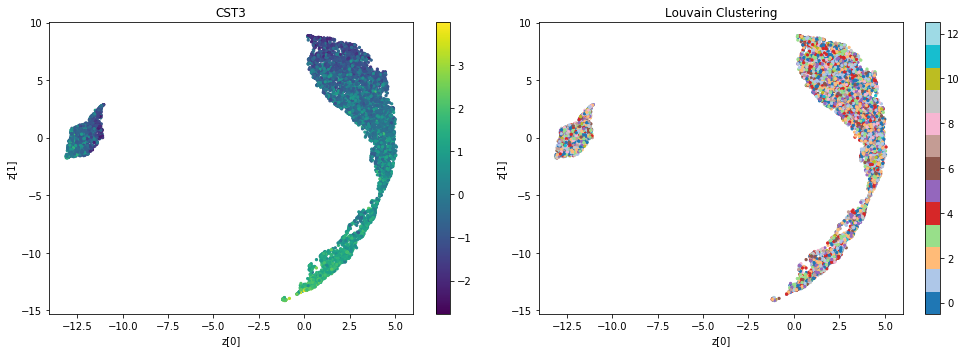

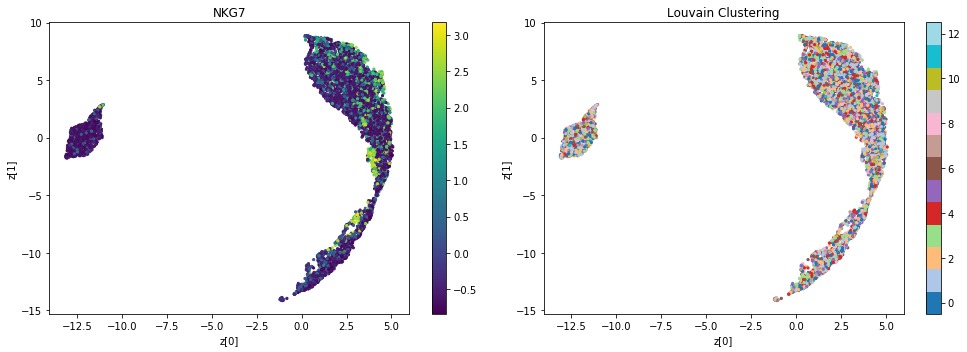

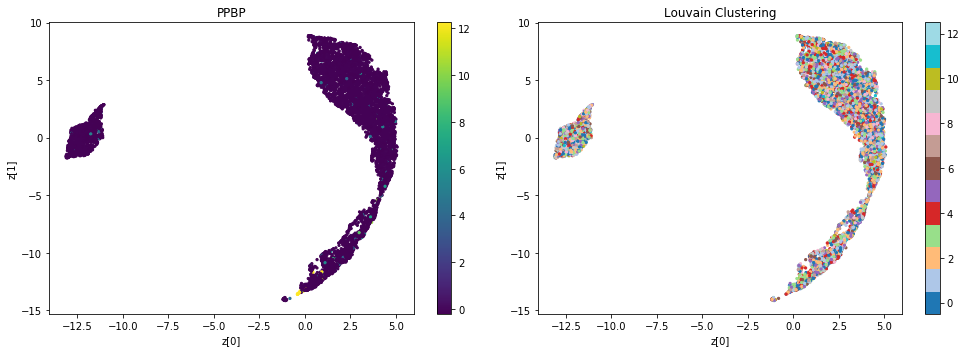

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## 2. Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc8k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1330)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1330)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          133000      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2', exist_ok=True)
model.export_graph('../graphs/AAE2')

Model graphs saved.



### Visualize graphs


ENCODER


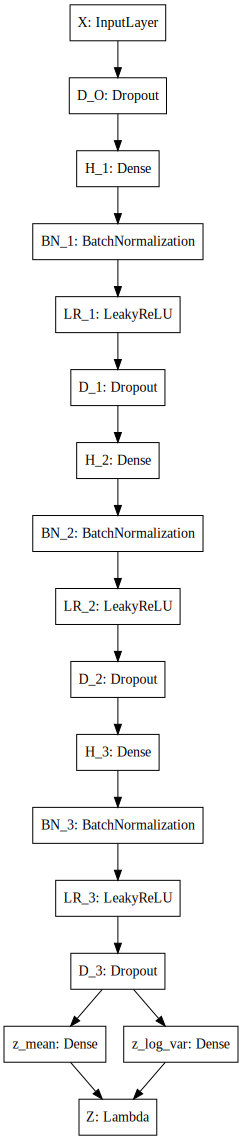

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


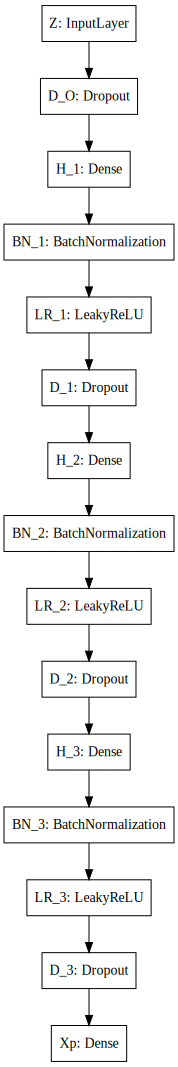

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


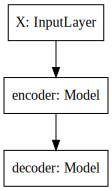

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


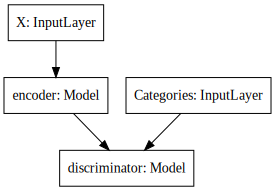

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


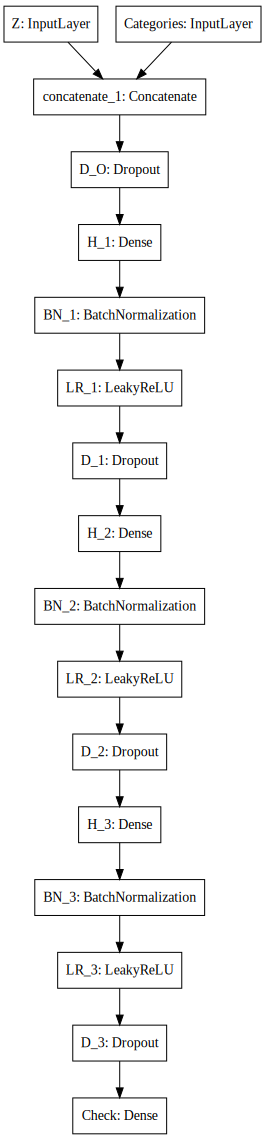

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.010608, generation loss: 0.410127, discriminator loss: 0.271828


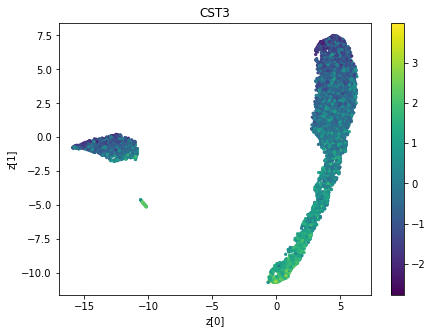

Training completed.


In [16]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2', exist_ok=True)
model.export_model('../models/AAE2')

All networks exported in h5 format.


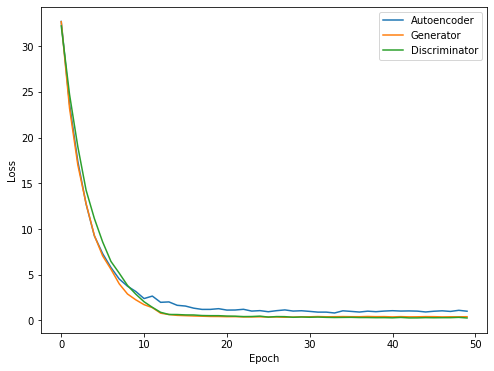

In [17]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

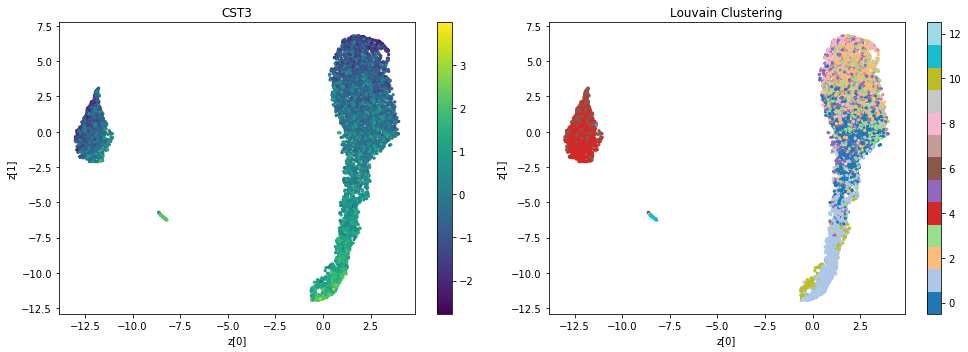

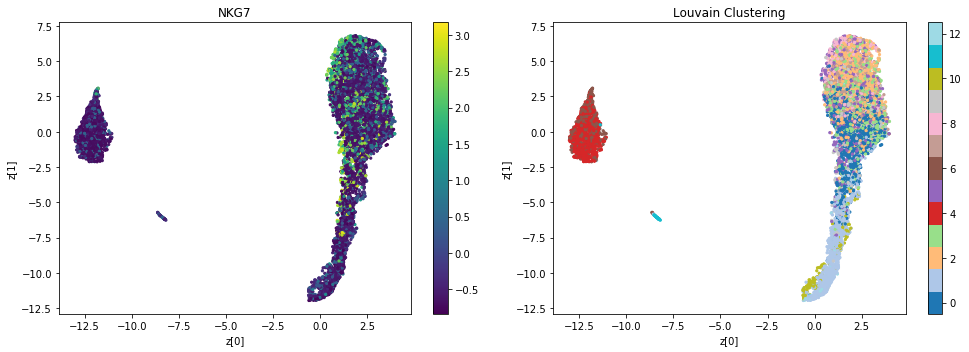

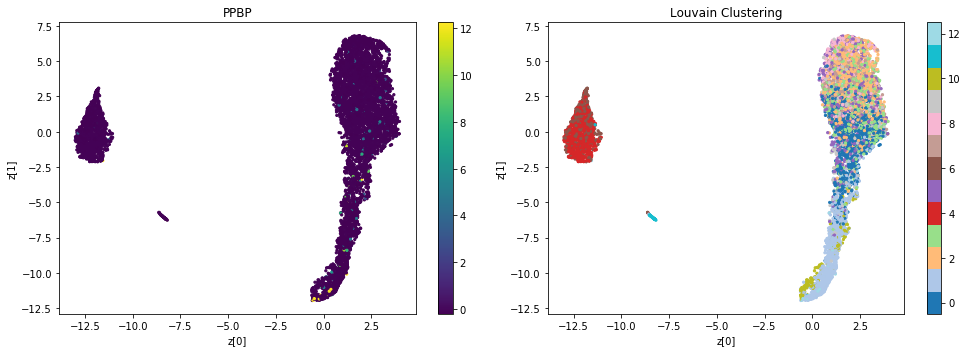

In [18]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

# Clustering analysis with Adversarial Autoencoders on 3k PBMC data


In [1]:
from keras.utils.vis_utils import model_to_dot
from keras.utils import normalize, to_categorical
from IPython.display import SVG

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import os

from imp import load_source
from utils import plot_results_pca, plot_results_umap, plot_results_louvain
from models import *

Using TensorFlow backend.


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False

## 1. Adversarial Autoencoder: Unsupervised Model

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE1(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [13]:
# Export model graphs

os.makedirs('../graphs/AAE1', exist_ok=True)
model.export_graph('../graphs/AAE1')

Model graphs saved.



### Visualize graphs


ENCODER


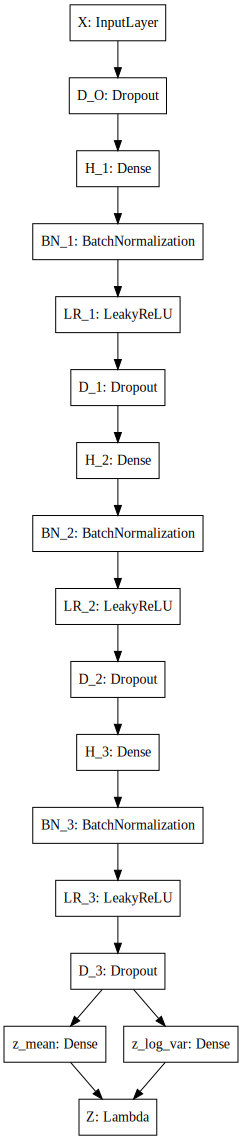

In [16]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


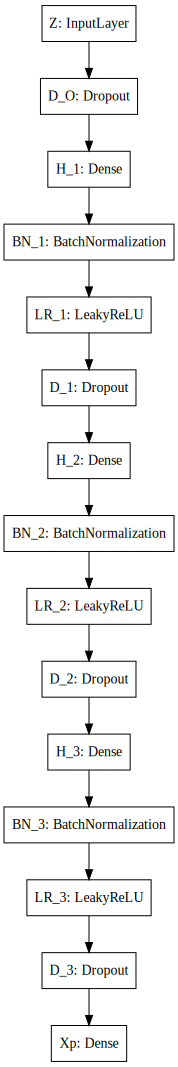

In [17]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


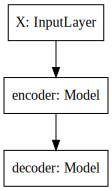

In [18]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


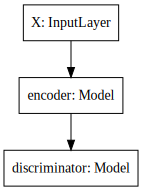

In [23]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


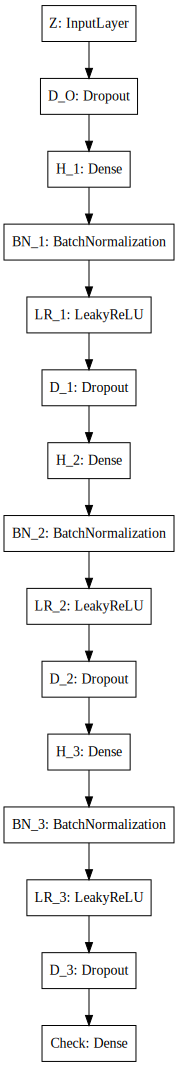

In [19]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.316368, generation loss: 0.451401, discriminator loss: 0.551019


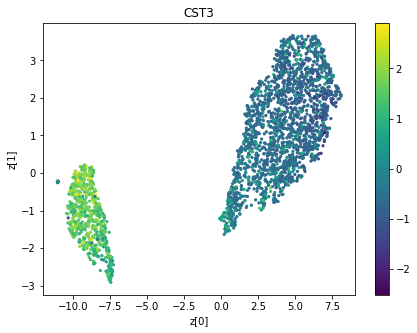

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [16]:
# save models in h5 format
os.makedirs('../models/AAE1', exist_ok=True)
model.export_model('../models/AAE1')

Adversarial Autoencoder networks exported in h5 format.


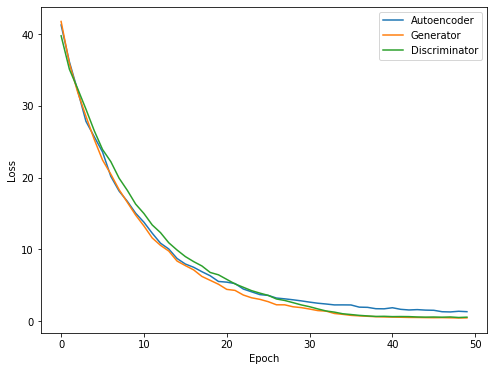

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

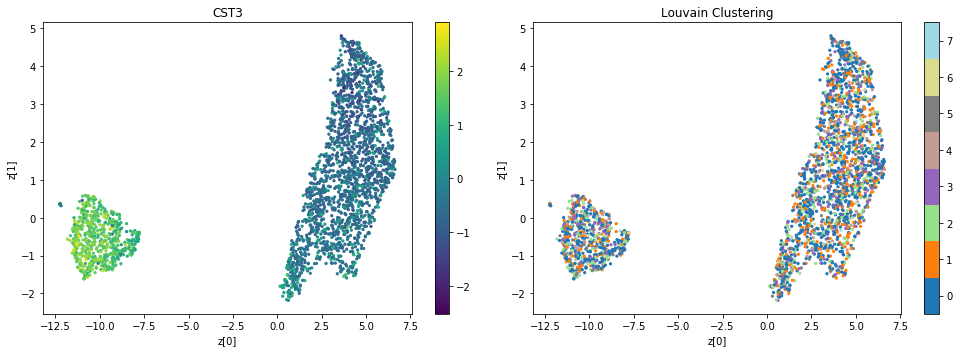

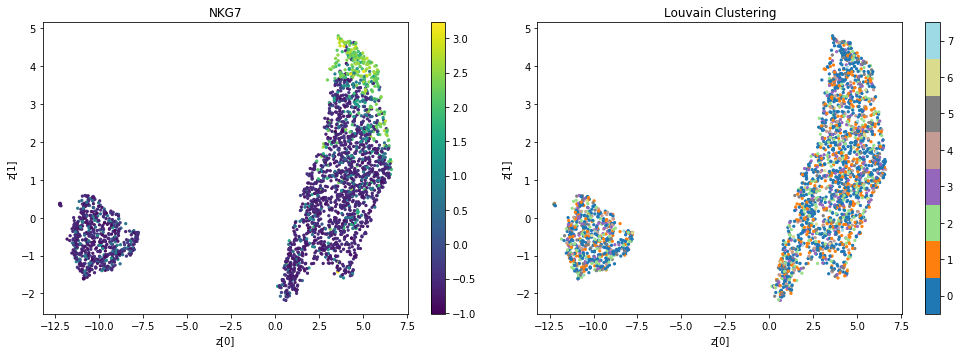

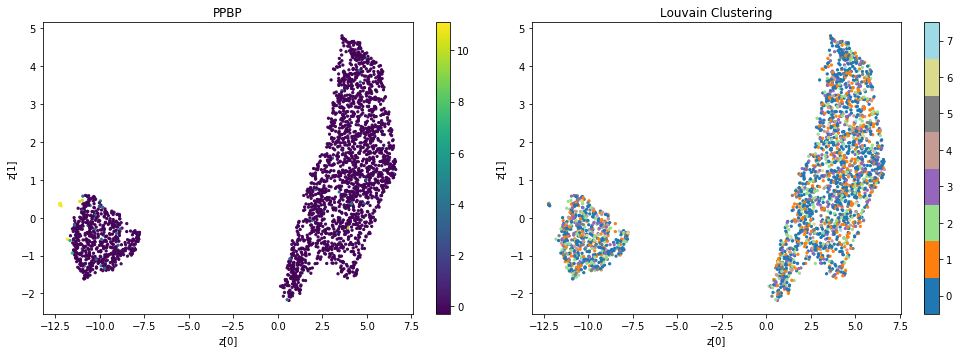

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)

## 2. Incorporating Label Information in the Adversarial Regularization

### Build the model

In [4]:
# Network parameters

layers_dim_enc = [100,50,50]
layers_dim_dec = [50,50,100]
layers_dim_dis = [50,50,100]
batch_size = 35
latent_dim = 50
epochs = 50

In [5]:
model = AAE2(latent_dim, 
             layers_dim_enc, layers_dim_dec, layers_dim_dis,
             batch_size=batch_size,
             epochs=epochs)

In [6]:
# Import dataset

data_path = '../data/proc/pbmc3k.h5ad'

model.load_data(data_path)

Dataset imported.


In [7]:
# Rescale gene expression data

model.rescale_data()

Gene expression data rescaled.


In [8]:
# Show network hyper-parameters

print("List of Network parameters")
model.get_parameters()

List of Network parameters


,Value,Description
latent_dim,50,dimension of latent space Z
layer_1_enc_dim,100,dimension of encoder dense layer 1
layer_2_enc_dim,50,dimension of encoder dense layer 2
layer_3_enc_dim,50,dimension of encoder dense layer 3
layer_1_dec_dim,50,dimension of decoder dense layer 1
layer_2_dec_dim,50,dimension of decoder dense layer 2
layer_3_dec_dim,100,dimension of decoder dense layer 3
layer_1_dis_dim,50,dimension of discriminator dense layer 1
layer_2_dis_dim,50,dimension of discriminator dense layer 2
layer_3_dis_dim,100,dimension of discriminator dense layer 3


In [9]:
# Build the full model

model.build_model()

In [10]:
# Model summary

model.get_summary()


Encoder Network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
X (InputLayer)                  (None, 1838)         0                                            
__________________________________________________________________________________________________
D_O (Dropout)                   (None, 1838)         0           X[0][0]                          
__________________________________________________________________________________________________
H_1 (Dense)                     (None, 100)          183800      D_O[0][0]                        
__________________________________________________________________________________________________
BN_1 (BatchNormalization)       (None, 100)          400         H_1[0][0]                        
____________________________________________________________________________________________

In [11]:
# Export model graphs

os.makedirs('../graphs/AAE2', exist_ok=True)
model.export_graph('../graphs/AAE2')

Model graphs saved.



### Visualize graphs


ENCODER


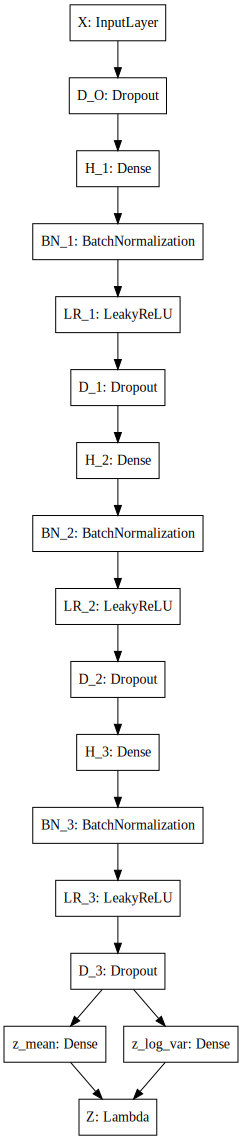

In [11]:
print("\nENCODER")
print("=======")
SVG(model_to_dot(model.encoder).create(prog='dot', format='svg'))


DECODER


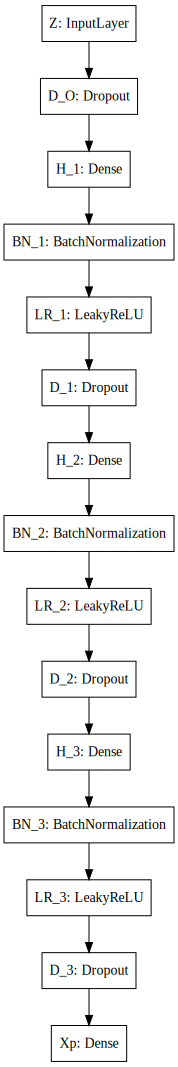

In [12]:
print("\nDECODER")
print("=======")
SVG(model_to_dot(model.decoder).create(prog='dot', format='svg'))


AUTOENCODER


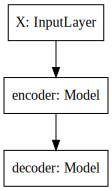

In [13]:
print("\nAUTOENCODER")
print("===========")
SVG(model_to_dot(model.autoencoder).create(prog='dot', format='svg'))


GENERATOR


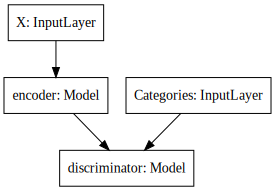

In [14]:
print("\nGENERATOR")
print("=========")
SVG(model_to_dot(model.generator).create(prog='dot', format='svg'))


DISCRIMINATOR


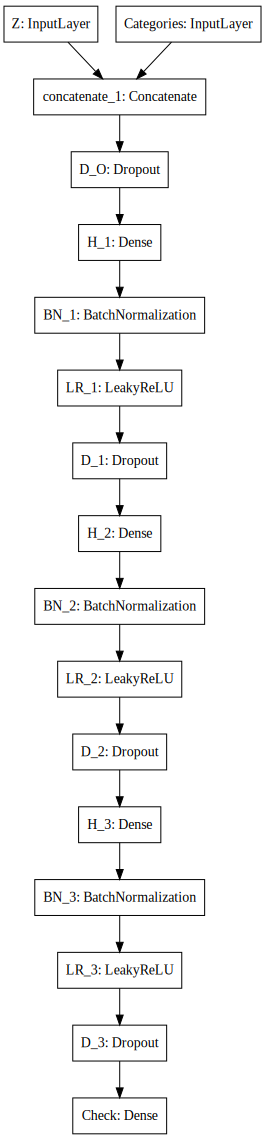

In [15]:
print("\nDISCRIMINATOR")
print("=============")
SVG(model_to_dot(model.discriminator).create(prog='dot', format='svg'))

### Train the model

Epoch 50/50, reconstruction loss: 1.633830, generation loss: 0.489770, discriminator loss: 0.547568


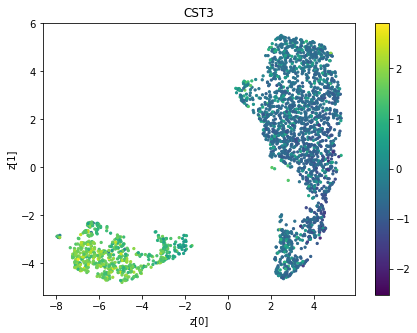

Training completed.


In [11]:
# graph=True to show the data points in the 2-D latent space

gene = 'CST3' # used only for training visualization 

rec_loss, gen_loss, disc_loss = model.train(graph=True, gene=gene)

In [18]:
# save models in h5 format
os.makedirs('../models/AAE2', exist_ok=True)
model.export_model('../models/AAE2')

All networks exported in h5 format.


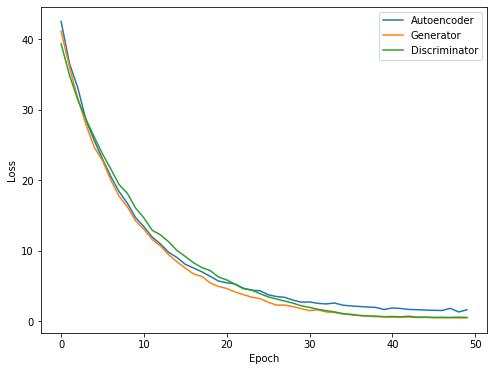

In [12]:
# Plot training & validation loss values

plt.figure(figsize=(8, 6))
axes = plt.gca()
plt.plot(rec_loss)
plt.plot(gen_loss)
plt.plot(disc_loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Autoencoder', 'Generator', 'Discriminator'], loc='upper right')
plt.show()

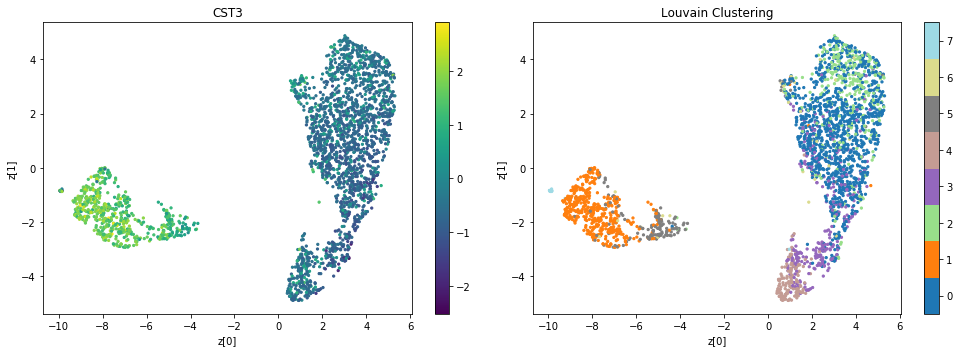

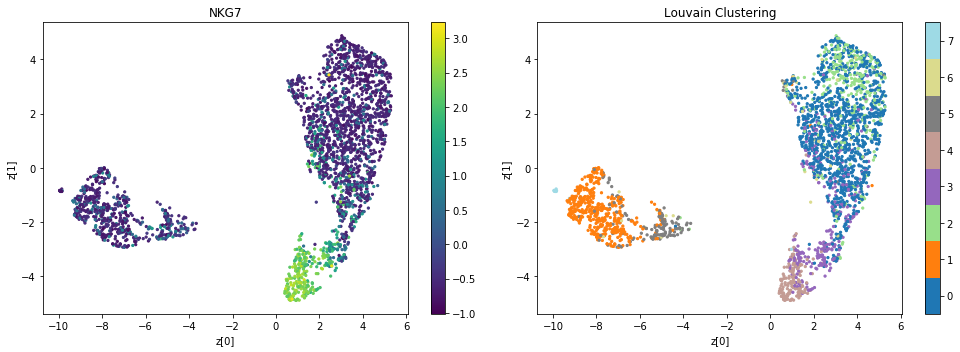

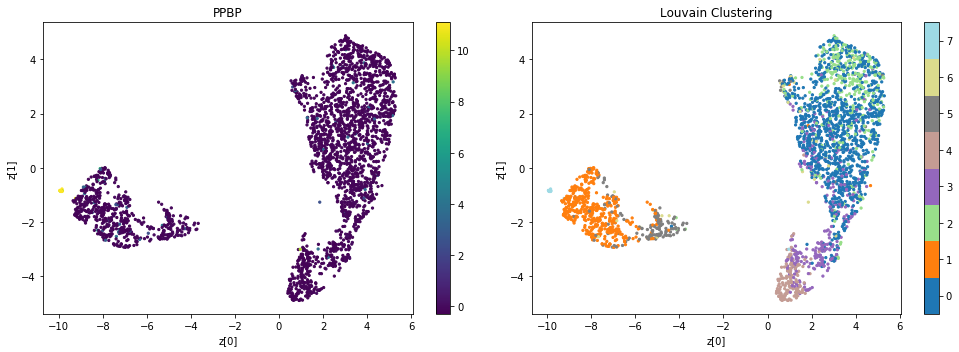

In [13]:
gene_list = ['CST3', 'NKG7', 'PPBP']
model.plot_umap(gene_selected=gene_list, louvain=True)